In [1]:
# GLOBAL VARIABLES. BE SURE NOT TO OVERWRITE THEM
D = 8 # Amount of documents
V = 12 # Size of the vocabulary

# (Approximate) Maximum allowed amount of same word repetition in a document (it may be lower in practise due to the data generation strategy)
# To get the actual maximum amount, call Simulator.get_M
M = 10 


k = 5 # Amount of topics
gamma = 0.2  #

In [2]:
# GLOBAL VARIABLES. BE SURE NOT TO OVERWRITE THEM
#D = 100 # Amount of documents
#V = 18 # Size of the vocabulary

# (Approximate) Maximum allowed amount of same word repetition in a document (it may be lower in practise due to the data generation strategy)
# To get the actual maximum amount, call Simulator.get_M
#M = 5 

#k = 6 # Amount of topics
#gamma = 0.2

# FA: Since we're testing so much, lets agree on using just 1 small set of global variables for now

In [3]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

From now on let's use the following simulated data for further testing

In [4]:
from simulator import Simulator

In [5]:
test_data = Simulator(D, V, M, k, gamma, seed=1967)  # Man on the moon
test_data.generate_all_data()

random_initial_data = Simulator(D, V, M, k, gamma, seed=1969)  # Woodstock Music Festival
random_initial_data.generate_all_data()

Success: Sigma transformed from K
Success: G transformed from K
Success: W and Z generated
Success: E transformed from Z
Success: C transformed from Z
Success: Sigma transformed from K
Success: G transformed from K
Success: W and Z generated
Success: E transformed from Z
Success: C transformed from Z


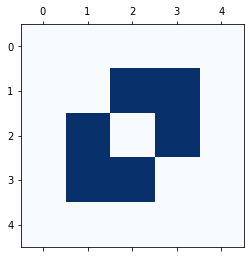

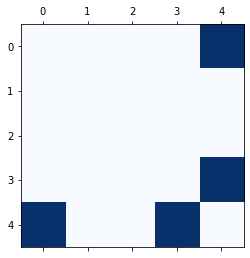

In [6]:
plt.matshow(test_data.G, cmap='Blues')
plt.matshow(random_initial_data.G, cmap='Blues')

# 2 MC SAMPLER

## 2.4.1 Sampling G and K (BDMCMC Sampling)

In [7]:
from samplers import serialize_matrix, deserialize_matrix

#### Serialization test

In [8]:
# This function is only used to test if the serialization and deserialization functions between R and python work properly
import subprocess


def serialization_function_test(n_tests=200, shape=(8,17)):    
    results = []
    for _ in range(n_tests):
        
        # Generate random matrix
        test_matrix = np.random.random(shape) * 100
        
        # Serialize matrix
        serialized_test_matrix = serialize_matrix(test_matrix)
        
        # Send to R script
        command = f"Rscript --vanilla serialize_matrix_test.R {serialized_test_matrix}"
        result = subprocess.run(command, 
                                shell=True, 
                                capture_output=True,
                                text=True)
        
        # Deserialize from R output
        deserialized_test_matrix = deserialize_matrix(result.stdout, shape=shape)
        differences = np.abs(test_matrix-deserialized_test_matrix)
        max_diff = np.max(differences)
        min_diff = np.min(differences)
        diff_sum = np.sum(differences)
        results.append({'max_diff': max_diff, 'min_diff': min_diff, 'diff_sum': diff_sum})
    return pd.DataFrame(results)

In [9]:
%%time
test_result_df = serialization_function_test()
test_result_df.head()

CPU times: user 254 ms, sys: 668 ms, total: 921 ms
Wall time: 26.6 s


,max_diff,min_diff,diff_sum
0,0.0,0.0,0.0
1,0.0,0.0,0.0
2,0.0,0.0,0.0
3,0.0,0.0,0.0
4,0.0,0.0,0.0


In [10]:
test_result_df.describe(percentiles=[i * 0.1 for i in range(1, 10)])

,max_diff,min_diff,diff_sum
count,2.000000e+02,200.0,2.000000e+02
mean,8.881784e-18,0.0,8.881784e-18
std,1.256074e-16,0.0,1.256074e-16
min,0.000000e+00,0.0,0.000000e+00
10%,0.000000e+00,0.0,0.000000e+00
20%,0.000000e+00,0.0,0.000000e+00
30%,0.000000e+00,0.0,0.000000e+00
40%,0.000000e+00,0.0,0.000000e+00
50%,0.000000e+00,0.0,0.000000e+00
60%,0.000000e+00,0.0,0.000000e+00


### Task:

You must implement a function that receives matrices $W$, $Z_{i+1}$ and $H_{i+1}$ and generates the next $G_{i+1}$ and $K_{i+1}$.

In [11]:
from samplers import MC_sample_GK

## 2.4.2 G and K Sampling Tests

#### MC_sample_GK tests

In [12]:
# Check that the function runs with no issues, without side effects
G_copy = random_initial_data.G.copy()
H_copy = test_data.H.copy()
degrees_of_freedom_b = k - 1
shape_matrix = np.eye(k)

wt_sample, G_sample, K_sample = MC_sample_GK(G_copy, H_copy, degrees_of_freedom_b, debug=True)

[1] "[R] Matrix G:"
     V1 V2 V3 V4 V5
[1,]  0  0  0  0  1
[2,]  0  0  0  0  0
[3,]  0  0  0  0  0
[4,]  0  0  0  0  1
[5,]  1  0  0  1  0
[1] "[R] Data Matrix:"
             V1        V2          V3          V4         V5
[1,]  4.8271696 -2.529908 -2.60905613  2.06795435  0.9204163
[2,] -2.5299083 20.108788  1.69769232  1.36241338  1.0238644
[3,] -2.6090561  1.697692 10.93384050 -0.01653776 -4.1524335
[4,]  2.0679544  1.362413 -0.01653776  4.42360858 -3.7338783
[5,]  0.9204163  1.023864 -4.15243354 -3.73387834  7.9064371
[1] "[R] Shape Matrix:"
     [,1] [,2] [,3] [,4] [,5]
[1,]    1    0    0    0    0
[2,]    0    1    0    0    0
[3,]    0    0    1    0    0
[4,]    0    0    0    1    0
[5,]    0    0    0    0    1
[1] "[R] Iterations:"
[1] 2
2 iteration is started.                     
 Iteration  2                 
[1] "[R] Waiting time:"
[1] 0.5688709
[1] "[R] Sampled Matrix G:"
   V1 V2 V3 V4 V5
V1  0  0  0  1  1
V2  0  0  0  0  0
V3  0  0  0  0  1
V4  1  0  0  0  1
V5  1  

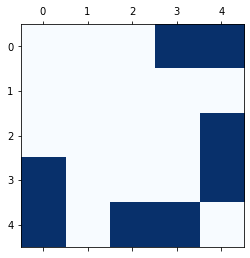

In [13]:
plt.matshow(G_sample, cmap='Blues')

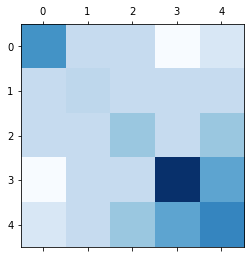

In [14]:
plt.matshow(K_sample, cmap='Blues')  # Why is this NOT a mask of G?

In [15]:
%%time
# Check that the Sampler works properly (This will take... forever)
K_errors = []
G_errors = []
wrong_edges = []
matrix_changes = []
burn_in = 0
for i in range(1000):
    K_sample_old = K_sample.copy()
    G_sample_old = G_sample.copy()
    wt_sample, G_sample, K_sample = MC_sample_GK(G_sample, H_copy, degrees_of_freedom_b, debug=False)
    matrix_changes.append(~np.all(K_sample_old == K_sample))
    if i >= burn_in:
        K_errors.append(np.linalg.norm(K_sample - test_data.K))  # Computing error wrt the target matrix        
        G_errors.append(np.linalg.norm(G_sample - test_data.G))  # Computing error wrt the target matrix
        wrong_edges.append(np.sum(np.abs(G_sample - test_data.G)))  # Computing error wrt the target matrix

CPU times: user 723 ms, sys: 2.84 s, total: 3.56 s
Wall time: 2min 50s


K matrix changes (1 = changed, 0 = same)
count    1000.0
mean        1.0
std         0.0
min         1.0
25%         1.0
50%         1.0
75%         1.0
max         1.0
dtype: float64


<AxesSubplot:>

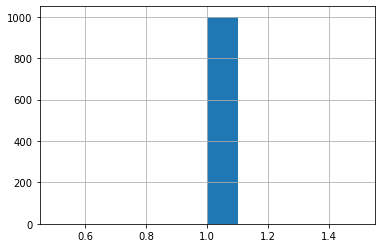

In [16]:
# K matrix should change
matrix_changes = pd.Series(matrix_changes).astype(int)
print("K matrix changes (1 = changed, 0 = same)")
print(matrix_changes.describe())
matrix_changes.hist()

K L2-error metrics
count    1000.000000
mean        2.135428
std         0.204435
min         1.748849
25%         2.023830
50%         2.111542
75%         2.214284
max         6.039950
dtype: float64


<AxesSubplot:>

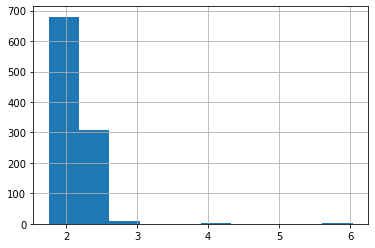

In [17]:
# Error should be distributed close to 0 (I guess...)  # BUG https://trello.com/c/9k2e8PQz/33-mcsampleh-is-not-close-to-expected-target
K_errors = pd.Series(K_errors)
print("K L2-error metrics")
print(K_errors.describe())
K_errors.hist()

K L2-error series


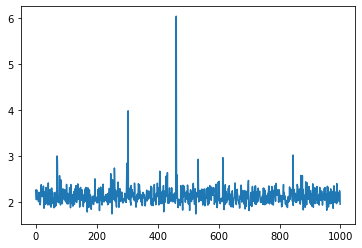

In [18]:
K_errors.plot()
print("K L2-error series")

G L2-error metrics
count    1000.000000
mean        3.167879
std         0.429802
min         2.449490
25%         3.162278
50%         3.162278
75%         3.162278
max         4.242641
dtype: float64


<AxesSubplot:>

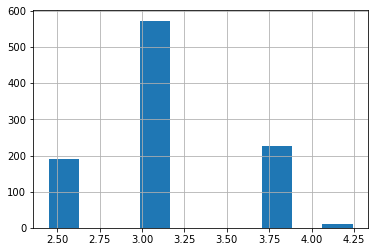

In [19]:
# Error should be distributed close to 0 (I guess...)  # BUG https://trello.com/c/9k2e8PQz/33-mcsampleh-is-not-close-to-expected-target
G_errors = pd.Series(G_errors)
print("G L2-error metrics")
print(G_errors.describe())
G_errors.hist()

G L2-error series


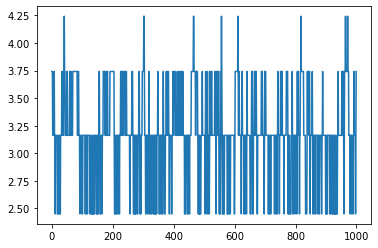

In [20]:
G_errors.plot()
print("G L2-error series")

G wrong edges count
count    1000.000000
mean       10.220000
std         2.696455
min         6.000000
25%        10.000000
50%        10.000000
75%        10.000000
max        18.000000
dtype: float64


<AxesSubplot:>

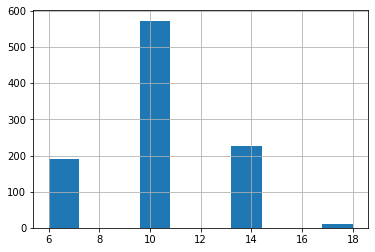

In [21]:
wrong_edges = pd.Series(wrong_edges)
print("G wrong edges count")
print(wrong_edges.describe())
wrong_edges.hist()

G wrong edges series


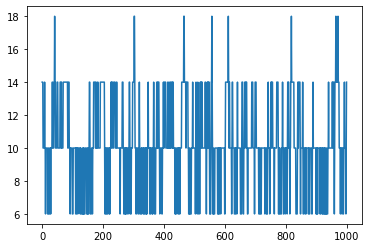

In [22]:
wrong_edges.plot()
print("G wrong edges series")